In [ ]:
!pip install --upgrade keras_cv tensorflow -q
!pip install --upgrade keras -q


In [ ]:
import keras
from keras_cv.layers import DropPath
from keras import ops
from keras import layers

import tensorflow as tf  # データローダーに必要
import tensorflow_datasets as tfds  # flower dataset

from skimage.data import chelsea
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
class SqueezeAndExcitation(layers.Layer):
    """ Squeeze-and-Excitationブロックの実装
        入力特徴マップの重要性を再計算して再スケーリングする

    Attributes:
        expansion (float): 入力チャンネル数に対する拡張率
        output_dim (int): 出力チャンネル数
        avg_pool (layers.GlobalAvgPool2D): グローバル平均プール層
        fc (list of layers.Layer): 全結合層と活性化関数からなるレイヤーのリスト
    """
    def __init__(self, output_dim=None, expansion=0.25, **kwargs):
        """
        Args:
            output_dim (int): 出力チャネンル数
            expansion (float): 入力チャンネル数に対する拡張率
            **kwargs: その他の引数
        """
        super().__init__(**kwargs)
        self.expansion = expansion  # 拡張率を設定
        self.output_dim = output_dim  # 出力チャンネル数を設定

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状。
        """
        inp = input_shape[-1]  # 入力チャンネル数を取得
        self.output_dim = self.output_dim or inp  # 出力チャンネル数を決定
        # グローバル平均プール層（Squeeze）
        self.avg_pool = layers.GlobalAvgPool2D(keepdims=True, name="avg_pool")
        # 全結合層と活性化関数のリスト(ボトルネック)
        self.fc = [
            # 全結合層1（チャンネル数の圧縮）
            layers.Dense(int(inp * self.expansion), use_bias=False, name="fc_0"),
            layers.Activation("gelu", name="fc_1"),  # GELU活性化関数
            # 全結合層2（チャンネル数の拡張）
            layers.Dense(self.output_dim, use_bias=False, name="fc_2"),
            layers.Activation("sigmoid", name="fc_3"),  # シグモイド活性化関数
        ]

        # スーパークラスlayers.Layerのbuild()メソッドに各レイヤーを渡す
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor): 入力テンソル
        Returns:
            Tensor: Squeeze-and-Excitationが適用された出力テンソル
        """
        x = self.avg_pool(inputs)  # グローバル平均プールを適用
        # ボトルネックの処理
        for layer in self.fc:
            x = layer(x)  # 全結合層と活性化関数を適用

        # xにinputsを適用することでスケーリングを行う
        return x * inputs

class ReduceSize(layers.Layer):
    """ 入力テンソルの空間サイズ(高さと幅)を減少させるレイヤー

    Attributes:
        pad1 (layers.ZeroPadding2D): ゼロパディング層1
        pad2 (layers.ZeroPadding2D): ゼロパディング層2
        conv (list of layers.Layer): 畳み込み層と活性化関数で構成されるレイヤーのリスト
        reduction (layers.Conv2D): サイズを縮小するための畳み込み層
        norm1 (layers.LayerNormalization): Layer Normalization層1
        norm2 (layers.LayerNormalization): Layer Normalization層2
    """
    def __init__(self, keepdims=False, **kwargs):
        """
        Args:
            keepdims (bool): 出力のチャンネル数を入力と同じに保つかどうかのフラグ
            **kwargs: その他の引数。
        """
        super().__init__(**kwargs)
        self.keepdims = keepdims  # keepdimsフラグを設定

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状
        """
        embed_dim = input_shape[-1]  # 入力チャンネル数を取得
        # 出力チャンネル数を決定
        dim_out = embed_dim if self.keepdims else 2 * embed_dim
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")  # ゼロパディング層1
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")  # ゼロパディング層2

        self.conv = [
            # Depthwise畳み込み層
            layers.DepthwiseConv2D(
                kernel_size=3, strides=1,
                padding="valid", use_bias=False, name="conv_0"),
            layers.Activation("gelu", name="conv_1"), # GELU活性化関数
            # SqueezeAndExcitationブロック
            SqueezeAndExcitation(name="conv_2"),
            # Pointwise(標準的1x1)畳み込み層
            layers.Conv2D(
                embed_dim, kernel_size=1, strides=1,
                padding="valid", use_bias=False, name="conv_3"),
        ]
        # サイズを縮小するための畳み込み層
        self.reduction = layers.Conv2D(
            dim_out, kernel_size=3, strides=2,
            padding="valid", use_bias=False, name="reduction")
        # Layer Normalization層1
        self.norm1 = layers.LayerNormalization(-1, 1e-05, name="norm1")
        # Layer Normalization層2
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor): 入力テンソル
        Returns:
            Tensor: 空間サイズが減少された出力
        """
        x = self.norm1(inputs)  # 入力を正規化
        xr = self.pad1(x)  # パディングを適用
        # Depthwise畳み込み層+GELU活性化関数、
        # SqueezeAndExcitationブロック、
        # Pointwise畳み込み層を順次、適用
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr  # 入力と結合し、残差接続を行う(勾配消失を防止)
        x = self.pad2(x)  # パディングを適用
        x = self.reduction(x)  # 空間サイズを縮小
        x = self.norm2(x)  # 出力を正規化
        return x

class MLP(layers.Layer):
    """ 多層パーセプトロン（MLP）の実装

    Attributes:
        hidden_features (int): 隠れ層のニューロン(ユニット)数
        out_features (int): 出力層のニューロン数
        activation (str): 活性化関数
        dropout (float): ドロップアウト率
        in_features (int): 入力のニューロン数
        fc1 (layers.Dense): 全結合層1
        act (layers.Activation): 活性化関数
        fc2 (layers.Dense): 全結合層2
        drop1 (layers.Dropout): ドロップアウト1
        drop2 (layers.Dropout): ドロップアウト2
    """
    def __init__(
            self,
            hidden_features=None,
            out_features=None,
            activation="gelu",
            dropout=0.0,
            **kwargs
    ):
        """
        Args:
            hidden_features (int, optional): 隠れ層のニューロン数
            out_features (int, optional): 出力層のニューロン数
            activation (str, optional): 活性化関数
            dropout (float, optional): ドロップアウト率
            **kwargs: その他の引数
        """
        super().__init__(**kwargs)
        self.hidden_features = hidden_features  # 隠れ層のニューロン数を設定
        self.out_features = out_features  # 出力層のニューロン数を設定
        self.activation = activation  # 活性化関数を設定
        self.dropout = dropout  # ドロップアウト率を設定

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状。
        """
        self.in_features = input_shape[-1]  # 入力のニューロン数を取得
        # 隠れ層のニューロン数を決定
        self.hidden_features = self.hidden_features or self.in_features
        # 出力層のニューロン数を決定
        self.out_features = self.out_features or self.in_features
        self.fc1 = layers.Dense(self.hidden_features, name="fc1")  # 全結合層1
        self.act = layers.Activation(self.activation, name="act")  # 活性化層
        self.fc2 = layers.Dense(self.out_features, name="fc2")  # 全結合層2
        self.drop1 = layers.Dropout(self.dropout, name="drop1")  # ドロップアウト1
        self.drop2 = layers.Dropout(self.dropout, name="drop2")  # ドロップアウト2

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor): 入力テンソル
        Returns:
            Tensor: MLPが適用された出力
        """
        x = self.fc1(inputs)  # 全結合層1を適用
        x = self.act(x)  # 活性化関数を適用
        x = self.drop1(x)  # ドロップアウト1を適用
        x = self.fc2(x)  # 全結合層2を適用
        x = self.drop2(x)  # ドロップアウト2を適用
        return x


In [ ]:
class PatchEmbed(layers.Layer):
    """ 画像をパッチに分割し、埋め込みベクトルに変換する

    Attributes:
        embed_dim (int): 埋め込みベクトルの次元
        pad (layers.ZeroPadding2D): パディングを適用する層
        proj (layers.Conv2D): 入力画像を埋め込みベクトルに変換する畳み込み層
        conv_down (ReduceSize): 入力画像のサイズを縮小するReduceSizeブロック
    """
    def __init__(self, embed_dim, **kwargs):
        """
        Args:
            embed_dim (int): 埋め込みベクトルの次元
            **kwargs: その他の引数
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # 埋め込みベクトルの次元を設定

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状
        """
        # パディング層
        self.pad = layers.ZeroPadding2D(1, name="pad")
        # 3x3のカーネルでストライド2で移動する畳み込み層
        # 隣との重複(3ピクセル分)があるパッチに分割する
        self.proj = layers.Conv2D(self.embed_dim, 3, 2, name="proj")
        # サイズを縮小するReduceSizeブロック
        self.conv_down = ReduceSize(keepdims=True, name="conv_down")

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor):
                入力テンソル(bs, 高さ, 幅, チャンネル数)
                            例: (bs, 224, 224, 3)
        Returns(Tensor):
            パッチ分割、埋め込みベクトルに変換されたテンソル
            (bs, パッチ数(高さ), パッチ数(幅), 各パッチのチャンネル次元)
            例: (bs, 56, 56, 64)
        """
        # パディングを適用
        # xの形状:(bs, 226, 226, 3)
        x = self.pad(inputs)
        # 畳み込み層で埋め込みベクトルに変換（画像をパッチに分割
        # 入力の形状が(bs, 226, 226, 3)の場合、
        # xの形状:(bs, 112, 112, 3) パッチの数=112x112=12,544
        x = self.proj(x)
        # サイズを縮小: (bs, 56, 56, 64)
        x = self.conv_down(x)

        return x  # 埋め込みベクトルに変換された出力を返す


In [ ]:
class FeatureExtraction(layers.Layer):
    """ 特徴抽出を行うブロック

    Attributes:
        keepdims (bool): 出力の空間サイズを入力と同じに保つかどうかのフラグ
        pad1(layers.ZeroPadding2D): ゼロパディング層1
        pad2(layers.ZeroPadding2D): ゼロパディング層2
        conv(list of layers.Layer): 畳み込み層、活性化関数、SqueezeAndExcitation
        pool (layers.MaxPool2D): 空間サイズを縮小するためのMaxPooling層
    """
    def __init__(self, keepdims=False, **kwargs):
        """
        Args:
            keepdims (bool): 出力の空間サイズを入力と同じに保つかどうかのフラグ
            **kwargs: その他の引数
        """
        super().__init__(**kwargs)
        self.keepdims = keepdims  # 出力の空間サイズのフラグをセット

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状
        """
        embed_dim = input_shape[-1]  # 入力の埋め込み次元を取得
        # 最初のゼロパディング層
        self.pad1 = layers.ZeroPadding2D(1, name="pad1")
        # 二番目のゼロパディング層
        self.pad2 = layers.ZeroPadding2D(1, name="pad2")

        # Depthwise畳み込み層と活性化関数、SqueezeAndExcitationを含むリスト
        self.conv = [
            # Depthwise畳み込み層
            layers.DepthwiseConv2D(3, 1, use_bias=False, name="conv_0"),
            layers.Activation("gelu", name="conv_1"), # GELU活性化関数
            SqueezeAndExcitation(name="conv_2"), # Squeeze-and-Excitation
            # Pointwiseみ込み層
            layers.Conv2D(embed_dim, 1, 1, use_bias=False, name="conv_3"),
        ]

        # MaxPooling層を設定（keepdimsがFalseの場合）
        if not self.keepdims:
            self.pool = layers.MaxPool2D(3, 2, name="pool")

        # スーパークラスのbuild()メソッドに入力の形状input_shapeを渡す
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        """
        フォワードパス

        Args:
            inputs (Tensor): 入力テンソル

        Returns:
            Tensor: 特徴抽出と空間サイズの調整が適用された出力テンソル
        """
        x = inputs  # 入力を取得
        xr = self.pad1(x)  # 最初のゼロパディングを適用
        # リストの畳み込み層、活性化関数、Squeeze-and-Excitationなどを順次適用
        for layer in self.conv:
            xr = layer(xr)
        x = x + xr  # 残差接続を適用
        # 二番目のゼロパディングとMaxPoolingを適用（keepdimsがFalseの場合）
        if not self.keepdims:
            x = self.pool(self.pad2(x))

        return x

class GlobalQueryGenerator(layers.Layer):
    """ グローバルクエリ生成器

    Attributes:
        keepdims (list of bool):
            各FeatureExtractionレイヤーが出力する空間サイズを
            入力と同じに保つかどうかのフラグリスト
        to_q_global (list of FeatureExtraction):
            グローバルクエリを生成するためのFeatureExtractionのリスト
    """
    def __init__(self, keepdims=False, **kwargs):
        """
        Args:
            keepdims (list of bool):
                各FeatureExtractionレイヤーの出力に関するフラグリスト
            **kwargs: その他の引数
        """
        super().__init__(**kwargs)
        self.keepdims = keepdims  # フラグリストを設定

    def build(self, input_shape):
        """
        レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状。
        """
        # keepdimsフラグリストに従ってFeatureExtractionブロックを配置
        self.to_q_global = [
            FeatureExtraction(keepdims, name=f"to_q_global_{i}")
            for i, keepdims in enumerate(self.keepdims)
        ]
        # スーパークラスのbuild()メソッドにinput_shapeを渡す
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        """
        フォワードパス

        Args:
            inputs (Tensor):
                パッチ分割、埋め込みベクトルに変換されたテンソル
                例: (bs, 56, 56, 64), (bs, 28, 28, 128), (1, 14, 14, 256)
        Returns:
            Tensor: グローバルクエリとして出力されたテンソル
        """
        x = inputs  # 入力を取得

        # 各レイヤーを順次適用
        # xの形状: (bs, 7, 7, 64), (bs, 7, 7, 128), (bs, 7, 7, 512)
        for layer in self.to_q_global:
            x = layer(x)

        return x


In [ ]:
class WindowAttention(layers.Layer):
    """ ウィンドウベースの自己注意機構(Self-Attention)

    Attributes:
        window_size (tuple of int): ウィンドウのサイズ
        num_heads (int): ヘッド数
        global_query (bool): グローバルクエリを使用するかどうかのフラグ
        qkv_bias (bool): qkv層にバイアスを使用するかどうかのフラグ
        qk_scale (float or None): スケーリング係数
        attention_dropout (float): アテンションスコアのドロップアウト率
        projection_dropout (float): 出力のドロップアウト率
        scale (float): q(クエリ)のスケーリング係数
        qkv_size (int): qkvのサイズ
        qkv (Dense):qkvを生成するための全結合層
        relative_position_bias_table (Tensor): 相対位置バイアステーブル
        attn_drop (Dropout): アテンションスコアのドロップアウト層
        proj (Dense): 出力の全結合層
        softmax (Activation): ソフトマックス関数
    """
    def __init__(
        self,
        window_size,
        num_heads,
        global_query,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        projection_dropout=0.0,
        **kwargs,
    ):
        """
        Args:
            window_size (int): ウィンドウのサイズ
                Lebel-1:7,  Lebel-2:7,  Lebel-3:14,  Lebel-4:7,
            num_heads (int): ヘッド数
                Lebel-1:2,  Lebe-2:4,  Lebe-3:8, Lebe-4:16,
            global_query (bool):
                グローバルクエリを使用するかどうかのフラグ
                Lebel-1:False,  Lebel-2:True,  Lebel-3:False,  Lebel-4:True,
            qkv_bias (bool):
                qkv層にバイアスを使用するかどうかのフラグ:すべてのLebelにおいてTrue
            qk_scale (float or None): スケーリング係数
                すべてのLebelにおいて:None
            attention_dropout (float):
                アテンションスコアのドロップアウト率: すべてのLebelにおいて 0.0
            projection_dropout (float):
                出力のドロップアウト率: すべてのLebelにおいて 0.0
            **kwargs: その他の引数。
        """
        super().__init__(**kwargs)
        self.window_size = (window_size, window_size)  # ウィンドウサイズを設定
        self.num_heads = num_heads  #ヘッド数を設定
        self.global_query = global_query  # グローバルクエリの使用フラグを設定
        self.qkv_bias = qkv_bias  # qkv層のバイアス使用フラグを設定
        self.qk_scale = qk_scale  # スケーリング係数を設定
        # アテンションスコアのドロップアウト率
        self.attention_dropout = attention_dropout
        # 出力のドロップアウト率
        self.projection_dropout = projection_dropout

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple):
                (bs*window_num,window-dim(window_size*window_size),チャンネル次元数)

                Lebel-1:
                [(bs*64, 49, 64)]
                [(bs*64, 49, 64), (1, 7, 7, 64)] ※グローバルクエリ有り
                Lebel-2:
                [(bs*16, 49, 128)]
                [(bs*16, 49, 128), (1, 7, 7, 128)] ※グローバルクエリ有り
                Lebel-3:
                [(bs*1, 196, 256)]
                [(bs*1, 196, 256), (1, 14, 14, 256)] ※グローバルクエリ有り
                [(bs*1, 196, 256)]
                [(bs*1, 196, 256), (1, 14, 14, 256)] ※グローバルクエリ有り
                [(bs*1, 196, 256)]
                [(bs*1, 196, 256), (1, 14, 14, 256)] ※グローバルクエリ有り
                Lebel-4
                [(bs*1, 49, 512)]
                [(bs*1, 49, 512), (1, 7, 7, 512)] ※グローバルクエリ有り
        """
        # 埋め込み次元(チャンネル次元)を取得
        # Lebel-1: 64, 64,
        # Lebel-2: 128, 128,
        # Lebel-3: 256, 256, 256, 256, 256, 256,
        # Lebel-4: 512, 512
        embed_dim = input_shape[0][-1]
        # ヘッドごとの次元を計算
        # 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32
        head_dim = embed_dim // self.num_heads
        # スケール係数を設定
        self.scale = self.qk_scale or head_dim**-0.5

        # qkvのサイズを設定
        # グローバルクエリあり:2
        # グローバルクエリなし:3
        # Lebel-1: 3, 2,
        # Lebel-2: 3, 2,
        # Lebel-3: 3, 2, 3, 2, 3, 2,
        # Lebel-4: 3, 2
        self.qkv_size = 3 - int(self.global_query)

        # qkv層を設定
        self.qkv = layers.Dense(
            embed_dim * self.qkv_size, use_bias=self.qkv_bias, name="qkv")

        # 相対位置バイアステーブルを作成
        self.relative_position_bias_table = self.add_weight(
            # 重みの名前
            name="relative_position_bias_table",
            # 重みの形状を設定
            shape=[
                # 相対位置の範囲を考慮した行数
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                # 列数は自己注意機構のヘッド数
                self.num_heads,
            ],
            # 標準偏差0.02の切断正規分布で初期化
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,  # 重みを学習可能なパラメーターにする
            dtype=self.dtype,  # データ型を設定
        )

        # アテンションスコアのドロップアウトを設定
        self.attn_drop = layers.Dropout(
            self.attention_dropout, name="attn_drop")

        # 出力の全結合層を設定
        # ユニット数: Lebel-1: 64, 64,
        #             Lebel-2: 128, 128,
        #             Lebel-3: 256, 256, 256, 256, 256, 256,
        #             Lebel-4: 512, 512
        self.proj = layers.Dense(embed_dim, name="proj")
        # 出力のドロップアウトを設定
        self.proj_drop = layers.Dropout(
            self.projection_dropout, name="proj_drop")
        # ソフトマックス関数を作成
        self.softmax = layers.Activation("softmax", name="softmax")

        super().build(input_shape)

    def get_relative_position_index(self):
        """ 相対位置インデックスを計算

        Returns:
            相対位置インデックス(Tensor)
                Lebel-1: (49, 49),(49, 49),
                Lebel-2: (49, 49),(49, 49),
                Lebel-3: (196, 196),(196, 196),(196, 196),
                         (196, 196),(196, 196),(196, 196),
                Lebel-4: (49, 49), (49, 49),
        """
        # ウィンドウの高さの座標を生成
        coords_h = ops.arange(self.window_size[0])
        # ウィンドウの幅の座標を生成
        coords_w = ops.arange(self.window_size[1])

        # 座標をスタック
        #  Lebel-1: (2, 7, 7), (2, 7, 7),
        #  Lebel-2: (2, 7, 7), (2, 7, 7),
        #  Lebel-3: (2, 14, 14), (2, 14, 14), (2, 14, 14),
        #           (2, 14, 14), (2, 14, 14), (2, 14, 14),
        #  Lebel-4: (2, 7, 7), (2, 7, 7)
        coords = ops.stack(ops.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        # 座標をフラット化
        # Lebel-1: (2, 49), (2, 49),
        # Lebel-2: (2, 49), (2, 49),
        # Lebel-3: (2, 196), (2, 196), (2, 196),
        #          (2, 196), (2, 196), (2, 196),
        # Lebel-4: (2, 49), (2, 49),
        coords_flatten = ops.reshape(coords, [2, -1])

        # 相対座標を計算
        # Lebel-1: (2, 49, 49), (2, 49, 49),
        # Lebel-2: (2, 49, 49), (2, 49, 49),
        # Lebel-3: (2, 196, 196), (2, 196, 196), (2, 196, 196),
        #          (2, 196, 196), (2, 196, 196), (2, 196, 196),
        # Lebel-4: (2, 49, 49), (2, 49, 49)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]

        # 軸を転置
        # Lebel-1: (49, 49, 2), (49, 49, 2),
        # Lebel-2: (49, 49, 2), (49, 49, 2),
        # Lebel-3: (196, 196, 2), (196, 196, 2), (196, 196, 2),
        #          (196, 196, 2), (196, 196, 2), (196, 196, 2),
        # Lebel-4: (49, 49, 2), (49, 49, 2),
        relative_coords = ops.transpose(relative_coords, axes=[1, 2, 0])

        # x成分,y成分の形状
        # Lebel-1: (49, 49), (49, 49),
        # Lebel-2: (49, 49), (49, 49),
        # Lebel-3: (196, 196), (196, 196), (196, 196),
        #          (196, 196), (196, 196), (196, 196),
        # Lebel-4: (49, 49), (49, 49),
        #
        # 相対座標のx成分を計算
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        # 相対座標のy成分を計算
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1

        # 相対座標をスケーリング
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)

        # 相対位置インデックスを計算
        # relative_position_indexの形状はx,y成分の形状と同じ
        relative_position_index = relative_coords_xx + relative_coords_yy

        return relative_position_index

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (list of Tensor):
                (bs*ウィンドウの数,
                ウィンドウの次元数(window_size*window_size),
                チャンネル次元数)

            Lebel-1
            window-num:64, window-size:7, window-dim;49, channel-dim:64
            (bs*64, 49, 64)
            (bs*64, 49, 64), (1, 7, 7, 64) ※グローバルクエリ有り

            Lebel-2
            window-num:16, window-size:7, window-dim;49, channel-dim:128
            (bs*16, 49, 128)
            (bs*16, 49, 128), (1, 7, 7, 128) ※グローバルクエリ有り

            Lebel-3
            window-num:1, window-size:14, window-dim;196, channel-dim:256
            (bs*1, 196, 256)
            (bs*1, 196, 256), (1, 14, 14, 256) ※グローバルクエリ有り
            (bs*1, 196, 256)
            (bs*1, 196, 256), (1, 14, 14, 256) ※グローバルクエリ有り
            (bs*1, 196, 256)
            (bs*1, 196, 256), (1, 14, 14, 256)]※グローバルクエリ有り

            Lebel-4
            window-num:1, window-size:7, window-dim;49, channel-dim:512
            (bs*1, 49, 512)
            (bs*1, 49, 512), (1, 7, 7, 512) ※グローバルクエリ有り

        Returns:
            x(Tensor):
                ウィンドウごとに自己自己注意機構が適用された出力テンソル
                形状は入力時と同じ:
                (bs*window-num, window-dim(window_size*window_size), channel-dim)
        """
        # グローバルクエリが存在する場合、入力テンソルと
        # グローバルクエリを分離し、バッチサイズを取得する
        # self.global_query: Lebel-1: False,True,
        #                    Lebel-2: False,True,
        #                    Lebel-3: False,True,False,True,False,True,
        #                    Lebel-4: False,True,
        if self.global_query:
            inputs, q_global = inputs # 入力テンソルとグローバルクエリを分離
            # グローバルクエリのバッチサイズを取得
            # すべてB = 1
            B = ops.shape(q_global)[0]
        else:
            inputs = inputs[0] # グローバルクエリがない場合、入力テンソルを取得

        # bs * window-num、window-dim, channel-dimを取得
        # Lebel-1: (bs*64, 49, 64), (bs*64, 49  64),
        # Lebel-2: (bs*16, 49, 128), (bs*16, 49  128),
        # Lebel-3: (bs*1,196, 256), (bs*1, 196, 256), (bs*1, 196, 256),
        #          (bs*1,196, 256), (bs*1, 196, 256), (bs*1, 196, 256),
        # Lebel-4: (bs*1, 49, 512), (bs*1, 49, 512),
        B_, N, C = ops.shape(inputs)

        # qkvを生成  形状:(bs * window-num, window-dim, channel * self.qkv_size)
        # Lebel-1: (bs*64, 49, 192), (bs*64, 49, 128),
        # Lebel-2: (bs*16, 49, 384), (bs*16, 49, 256),
        # Lebel-3: (bs*1, 196, 768), (bs*1, 196, 512), (bs*1, 196, 768),
        #          (bs*1, 196, 512), (bs*1, 196, 768), (bs*1, 196, 512),
        # Lebel-4: (bs*1, 49, 1536), (bs*1, 49, 1024),
        qkv = self.qkv(inputs)

        # qkvテンソルをヘッドごとに分割し、ウィンドウに対応する形状にリシェイプ
        # (bs*window-num,window-dim, q.k.vのサイズ(3または2),ヘッド数,ヘッドの次元数)
        # Lebel-1: (bs*64, 49, 3, 2, 32), (bs*64, 49, 2, 2, 32),
        #          (bs*16, 49, 3, 4, 32), (bs*16, 49, 2, 4, 32),
        # Lebel-2: (bs*1, 196, 3, 8, 32),(bs*1, 196, 2, 8, 32),(bs*1, 196, 3, 8, 32),
        #          (bs*1, 196, 2, 8, 32),(bs*1, 196, 3, 8, 32),(bs*1, 196, 2, 8, 32),
        # Lebel-3: (bs*1, 49, 3, 16, 32), (bs*1, 49, 2, 16, 32),
        qkv = ops.reshape(
            qkv, [B_, N, self.qkv_size, self.num_heads, C // self.num_heads])

        # qkvの次元を入れ換える
        # (q.k.vのサイズ(3 or 2), bs*window-num, ヘッド数, window-dim, ヘッドの次元数)
        # Lebel-1: (3, bs*64, 2, 49, 32), (2, bs*64, 2, 49, 32),
        # Lebel-2: (3, bs*16, 4, 49, 32), (2, bs*16, 4, 49, 32),
        # Lebel-3: (3, bs*1, 8, 196, 32),(2, bs*1, 8, 196, 32),(3, bs*1, 8, 196, 32),
        #          (2, bs*1, 8, 196, 32),(3, bs*1, 8, 196, 32),(2, bs*1, 8, 196, 32),
        # Lebel-4: (3, bs*1, 16, 49, 32),(2, bs*1, 16, 49, 32),
        qkv = ops.transpose(qkv, [2, 0, 3, 1, 4])

        # グローバルクエリの有無に応じてqkvテンソルを適切に分割および整形する
        # k,vそれぞれの形状
        # Lebel-1: (1, bs*64, 2, 49, 32), (1, bs*64, 2, 49, 32),
        # Lebel-2: (1, bs*16, 4, 49, 32), (1, bs*16, 4, 49, 32),
        # Lebel-3: (1, bs*1, 8, 196, 32),(1, bs*1, 8, 196, 32),(1, bs*1, 8, 196, 32),
        #          (1, bs*1, 8, 196, 32),(1, bs*1, 8, 196, 32),(1, bs*1, 8, 196, 32),
        # Lebel-4: (1, bs*1, 16, 49, 32), (1, bs*1, 16, 49, 32),
        # qの形状
        # Lebel-1: (bs*64, 2, 49, 32), (bs*64, 2, 49, 32),
        # Lebel-2: (bs*16, 4, 49, 32), (bs*16, 4, 49, 32),
        # Lebel-3: (bs*1, 8, 196, 32), (bs*1, 8, 196, 32), (bs*1, 8, 196, 32),
        #          (bs*1, 8, 196, 32), (bs*1, 8, 196, 32), (bs*1, 8, 196, 32),
        # Lebel-4: (bs*1, 16, 49, 32), (bs*1, 16, 49, 32),
        if self.global_query:
            # qkvテンソルをキー（k）とバリュー（v）に分割
            k, v = ops.split(qkv, indices_or_sections=2, axis=0)
            # グローバルクエリを全てのパッチに適用
            # Bはバッチの数、B_はグロバルクエリのバッチ数なのですべてB_ = 1
            q_global = ops.repeat(q_global, repeats=B_ // B, axis=0)
            # qをリシェイプ
            q = ops.reshape(q_global, [B_, N, self.num_heads, C // self.num_heads])
            q = ops.transpose(q, axes=[0, 2, 1, 3])  # 軸を転置
        else:
            # グローバルクエリがない場合、
            # qkvテンソルを通常の方法で分割して形状を整える
            q, k, v = ops.split(qkv, indices_or_sections=3, axis=0)
            q = ops.squeeze(q, axis=0)

        # k,vの第1次元(0番目の次元)をそれぞれ削除
        k = ops.squeeze(k, axis=0)
        v = ops.squeeze(v, axis=0)

        # qをスケーリング
        q = q * self.scale
        # ウィンドウベースのアテンションスコアを計算
        # attnの形状: (bs*window-num, ヘッドの数, window-dim, window-dim)
        # Lebel-1: (bs*64, 2, 49, 49), (bs*64, 2, 49, 49),
        #          (bs*16, 4, 49, 49), (bs*16, 4, 49, 49),
        # Lebel-2: (bs*1, 8, 196, 196), (bs*1, 8, 196, 196), (bs*1, 8, 196, 196),
        #          (bs*1, 8, 196, 196), (bs*1, 8, 196, 196), (bs*1, 8, 196, 196),
        # Lebel-3: (bs*1, 16, 49, 49), (bs*1, 16, 49, 49),
        attn = q @ ops.transpose(k, axes=[0, 1, 3, 2])

        # 相対位置バイアステーブルから相対位置バイアスを取得してリシェイプし、
        # 自己注意機構に適用できる形状に整える
        # Lebel-1: (2401,), (2401,),
        # Lebel-2: (2401,), (2401,).
        # Lebel-3: (38416,), (38416,), (38416,),
        #          (38416,), (38416,), (38416,),
        # Lebel-4: (2401,), (2401,),
        relative_position_bias = ops.take(
            self.relative_position_bias_table,  # 相対位置バイアステーブルから値を取得
            ops.reshape(
                self.get_relative_position_index(),  # 相対位置インデックスを取得
                [-1]  # フラットにリシェイプ
            )
        )

        # 相対位置バイアスをリシェイプ
        # Lebel-1: (49, 49, 1), (49, 49, 1),
        # Lebel-2: (49, 49, 1), (49, 49, 1),
        # Lebel-3: (196, 196, 1), (196, 196, 1), (196, 196, 1),
        #          (196, 196, 1), (196, 196, 1), (196, 196, 1),
        # Lebel-4: (49, 49, 1), (49, 49, 1),
        relative_position_bias = ops.reshape(
            relative_position_bias,  # 取得した相対位置バイアス
            [
                self.window_size[0] * self.window_size[1], # ウィンドウの高さ*ウィンドウの幅
                self.window_size[0] * self.window_size[1], # ウィンドウの高さ*ウィンドウの幅
                -1  # チャンネル数は保持
            ]
        )

        # relative_position_biasの次元の並びを入れ換える
        # Lebel-1: (1, 49, 49), (1, 49, 49),
        #          (49, 49, 1), (1, 49, 49),
        # Lebel-2: (1, 196, 196), (1, 196, 196), (1, 196, 196),
        #          (1, 196, 196), (1, 196, 196), (1, 196, 196),
        # Lebel-3: (1, 49, 49), (1, 49, 49),
        relative_position_bias = ops.transpose(
            relative_position_bias,  # 相対位置バイアス
            axes=[2, 0, 1]  # 新しい軸(次元)の順序を指定
        )

        # ウィンドウベースのアテンションスコアに相対位置バイアスを加算
        # Lebel-1: (bs*64, 2, 49, 49), (bs*64, 2, 49, 49),
        # Lebel-2: (bs*16, 4, 49, 49), (bs*16, 4, 49, 49),
        # Lebel-3: (bs*1, 8, 196, 196), (bs*1, 8, 196, 196), (bs*1, 8, 196, 196),
        #          (bs*1, 8, 196, 196), (bs*1, 8, 196, 196), (bs*1, 8, 196, 196),
        # Lebel-4: (bs*1, 16, 49, 49), (bs*1, 16, 49, 49),
        attn = attn + relative_position_bias[None,]

        attn = self.softmax(attn)  # ソフトマックスを適用
        attn = self.attn_drop(attn)  # ドロップアウトを適用

        # アテンションスコアでvを重み付けし、転置
        # xの形状: (bs*womdpw-num, window-dim, ヘッド数, ヘッドの次元数)
        # Lebel-1: (bs*64, 49, 2, 32), (bs*64, 49, 2, 32),
        # Lebel-2: (bs*16, 49, 4, 32), (bs*16, 49, 4, 32),
        # Lebel-3: (bs*1, 196, 8, 32), (bs*1, 196, 8, 32), (bs*1, 196, 8, 32),
        #          (bs*1, 196, 8, 32), (bs*1, 196, 8, 32), (bs*1, 196, 8, 32),
        # Lebel-4: (bs*1, 49, 16, 32), (bs*1, 49, 16, 32),
        x = ops.transpose((attn @ v), axes=[0, 2, 1, 3])

        # 出力をリシェイプ
        # xの形状:(bs*window-num, window-dim(window_size*window_size), channel-dim)
        # Lebel-1: (bs*64, 49, 64), (bs*64, 49, 64),
        # Lebel-2: (bs*16, 49, 128), (bs*16, 49, 128),
        # Lebel-3: (bs*1, 196, 256), (bs*1, 196, 256), (bs*1, 196, 256),
        #          (bs*1, 196, 256), (bs*1, 196, 256), (bs*1, 196, 256),
        # Lebel-4: (bs*1, 49, 512), (bs*1, 49, 512),
        x = ops.reshape(x, [B_, N, C])

        # 全結合層とドロップアウトを適用
        x = self.proj_drop(self.proj(x))

        return x


In [ ]:
class Block(layers.Layer):
    """ GCViTの基本ブロック

    ウィンドウベースの自己注意機構WindowAttentionとMLPを組み合わせて
    入力特徴マップを処理する

    Attributes:
        window_size (int): ウィンドウのサイズ
        num_heads (int): 自己注意機構のヘッド数。
        global_query (bool): グローバルクエリを使用するかどうかのフラグ
        mlp_ratio (float): MLPの隠れ層のサイズ比率
        qkv_bias (bool): qkv層にバイアスを使用するかどうかのフラグ
        qk_scale (float or None): スケール係数
        dropout (float): ドロップアウト率
        attention_dropout (float): アテンションスコアのドロップアウト率
        path_drop (float): パスドロップのドロップアウト率
        activation (str): 活性化関数
        layer_scale (float or None): レイヤースケールの初期値
        norm1 (LayerNormalization): 正規化層1
        attn (WindowAttention): ウィンドウベースの自己注意機構
        drop_path1 (DropPath): ドロップパス層1
        drop_path2 (DropPath): ドロップパス層2
        norm2 (LayerNormalization): 正規化層2
        mlp (MLP): MLP層。
        gamma1 (Tensor): レイヤースケールパラメータ1
        gamma2 (Tensor): レイヤースケールパラメータ2
        num_windows (int): ウィンドウの数
    """
    def __init__(
        self,
        window_size, num_heads,
        global_query,
        mlp_ratio=4.0,
        qkv_bias=True, qk_scale=None,
        dropout=0.0, attention_dropout=0.0, path_drop=0.0,
        activation="gelu",
        layer_scale=None,
        **kwargs,
    ):
        """
        Args:
            window_size (int): ウィンドウのサイズ
                               Lv1:7,  Lv2:7,  Lv3:14,  Lv4:7
            num_heads (int): 自己注意機構のヘッド数
                             Lv1:2,  Lv2:4,  Lv3:8,  Lv4:16
            global_query (bool): グローバルクエリを使用するかどうかのフラグ
            mlp_ratio (float): MLPの隠れ層のサイズ比率。デフォルトは4.0。
            qkv_bias (bool):
                qkv層にバイアスを使用するかどうかのフラグ。デフォルトはTrue。
            qk_scale (float or None):
                スケール係数。Noneの場合はデフォルト値を使用。

            dropout (float): ドロップアウト率。デフォルトは0.0。
            attention_dropout (float):
                アテンションスコアのドロップアウト率。デフォルトは0.0。

            path_drop (float): パスドロップのドロップアウト率。デフォルトは0.0。
            activation (str): 活性化関数。デフォルトは"gelu"。

            layer_scale (float or None):
                レイヤースケールの初期値。Noneの場合はスケールを適用しない。

            **kwargs: その他の引数。
        """
        super().__init__(**kwargs)
        self.window_size = window_size  # ウィンドウサイズを設定
        self.num_heads = num_heads  # 自己注意機構のヘッド数を設定
        self.global_query = global_query  # グローバルクエリの使用フラグを設定
        self.mlp_ratio = mlp_ratio  # MLPの隠れ層のサイズ比率を設定
        self.qkv_bias = qkv_bias  # qkv層のバイアス使用フラグを設定
        self.qk_scale = qk_scale  # スケール係数を設定
        self.dropout = dropout  # ドロップアウト率を設定
        # アテンションスコアのドロップアウト率を設定
        self.attention_dropout = attention_dropout
        self.path_drop = path_drop  # パスドロップのドロップアウト率を設定
        self.activation = activation  # 活性化関数を設定
        self.layer_scale = layer_scale  # レイヤースケールの初期値を設定

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状
        """
        # 入力の形状からバッチサイズ、高さ、幅、チャンネル数を取得
        B, H, W, C = input_shape[0]
        # 正規化層1を作成
        self.norm1 = layers.LayerNormalization(-1, 1e-05, name="norm1")
        # ウィンドウベースの自己注意層WindowAttentionを作成
        self.attn = WindowAttention(
            window_size=self.window_size,  # ウィンドウサイズ
            num_heads=self.num_heads,  # 注意機構のヘッド数
            global_query=self.global_query,  # グローバルクエリの使用フラグ
            qkv_bias=self.qkv_bias,  # qkv層のバイアス使用フラグ
            qk_scale=self.qk_scale,  # スケール係数
            attention_dropout=self.attention_dropout, # スコアのドロップアウト率
            projection_dropout=self.dropout, # 出力のドロップアウト率
            name="attn",
        )
        self.drop_path1 = DropPath(self.path_drop)  # ドロップパス層1を作成
        self.drop_path2 = DropPath(self.path_drop)  # ドロップパス層2を作成
        # 正規化層2を設定
        self.norm2 = layers.LayerNormalization(-1, 1e-05, name="norm2")
        # MLPブロックを作成
        self.mlp = MLP(
            hidden_features=int(C * self.mlp_ratio),  # 隠れ層のサイズを設定
            dropout=self.dropout,  # ドロップアウト率を設定
            activation=self.activation,  # 活性化関数を設定
            name="mlp",
        )

        # レイヤースケールがNone以外の場合
        if self.layer_scale is not None:
            # レイヤースケールパラメータ1を設定
            self.gamma1 = self.add_weight(
                name="gamma1", # 重みの名前を設定
                shape=[C], # 重みの形状を設定
                # 初期値としてゼロを設定
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True, # 学習可能に設定
                dtype=self.dtype, # データ型を設定
            )
            # レイヤースケールパラメータ2を設定
            self.gamma2 = self.add_weight(
                name="gamma2", # 重みの名前を設定
                shape=[C], # 重みの形状を設定
                # 初期値としてゼロを設定
                initializer=keras.initializers.Constant(self.layer_scale),
                trainable=True, # 学習可能に設定
                dtype=self.dtype, # データ型を設定
            )
        else:
            self.gamma1 = 1.0  # レイヤースケールパラメータ1の値を1.0に設定
            self.gamma2 = 1.0  # レイヤースケールパラメータ2の値を1.0に設定

        # ウィンドウの数を計算
        # Lv1; 64, 64.
        # Lv2: 16. 16.
        # Lv3: 1, 1, 1, 1, 1, 1,
        # Lv4: 1, 1,
        self.num_windows = int(H // self.window_size) * int(W // self.window_size)
        # スーパークラスのbuild()メソッドにinput_shapeを渡す
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor): (bs, 特徴高さ, 特徴幅, 特徴のチャンネル次元数)
            Level-1: (bs, 56, 56, 64), (bs, 56, 56, 64)
            Level-2: (bs, 28, 28, 128), (bs, 28, 28, 128)
            Level-3: (bs, 14, 14, 256), (bs, 14, 14, 256), (bs, 14, 14, 256)
                     (bs, 14, 14, 256), (bs, 14, 14, 256), (bs, 14, 14, 256)
            Level-4: (bs, 7, 7, 512), (bs, 7, 7, 512)

        Returns:
            x(Tensor):
                ウィンドウベースの自己注意機構とMLPが適用されたテンソル
                形状は入力と同じ(bs, 特徴高さ, 特徴幅, 特徴のチャンネル次元数)
        """
        # グローバルクエリが存在する場合
        if self.global_query:
            inputs, q_global = inputs
        else:
            inputs = inputs[0]

        # バッチサイズ、高さ、幅、チャンネル数を取得
        B, H, W, C = ops.shape(inputs)

        # inputsテンソルに正規化層1を適用
        x = self.norm1(inputs)

        # xをウィンドウに分割
        # (ウィンドウの数*bs, window_size(高さ), window_size(幅), チャンネル次元数)
        x = self.window_partition(x, self.window_size)
        # window_sizeの次元をフラット化
        # (bs*ウィンドウの数, ウィンドウの次元数, チャンネル次元数)
        x = ops.reshape(x, [-1, self.window_size * self.window_size, C])

        # ウィンドウベースの自己注意機構を適用
        if self.global_query:
            # グローバルクエリが存在する場合
            x = self.attn([x, q_global])
        else:
            # グローバルクエリが存在しない場合
            x = self.attn([x])

        # ウィンドウの分割を元に戻す
        x = self.window_reverse(x, self.window_size, H, W, C)
        # xをスケーリングしてドロップパス層1を適用
        x = inputs + self.drop_path1(x * self.gamma1)
        # xとMLP層を適用し、スケーリングした後のxを残差接続する
        # この残差接続処理をドロップパス層2に組み込む(Stochastic Depth)
        x = x + self.drop_path2(self.gamma2 * self.mlp(self.norm2(x)))

        return x  # 出力を返す

    def window_partition(self, x, window_size):
        """ ウィンドウへの分割処理を行う
        Args:
            x: (bs, 特徴高さ, 特徴幅, 特徴のチャンネル次元数)
            window_size: window size
        Returns:
            (ウィンドウの数*bs, window_size, window_size, 特徴のチャンネル次元数)
        """
        B, H, W, C = ops.shape(x)  # バッチサイズ、高さ、幅、チャンネル数を取得
        x = ops.reshape(
            x,
            [
                -1, # 0番目の次元数は自動計算
                H // window_size,  # ウィンドウの高さを計算
                window_size,  # ウィンドウの高さを設定
                W // window_size,  # ウィンドウの幅を計算
                window_size,  # ウィンドウの幅を設定
                C,  # チャンネル数を設定
            ],
        )
        # 軸(次元)を入れ換える
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        # テンソルの形状を変更
        # (ウィンドウの数*bs, windows, window_size, チェンネル次元数)
        windows = ops.reshape(x, [-1, window_size, window_size, C])
        return windows  # ウィンドウ分割後のテンソルを返す

    def window_reverse(self, windows, window_size, H, W, C):
        """ ウィンドウへの分割を解除してテンソルを元の形状に戻す
        Args:
            windows:
                (ウィンドウの数*bs, window_size, window_size, 特徴のチャンネル次元数)
            window_size: ウィンドウ1辺のサイズ
            H: 元の特徴高さ
            W: 元の特徴幅
            C: チャンネル次元数
        Returns:
            x: (bs, 特徴高さ, 特徴幅, 特徴のチャンネル次元数)
        """
        x = ops.reshape(
            windows,
            [
                -1, # 0番目の次元数は自動計算
                H // window_size,  # ウィンドウの高さ方向の数を計算
                W // window_size,  # ウィンドウの幅方向の数を計算
                window_size,  # ウィンドウの高さを設定
                window_size,  # ウィンドウの幅を設定
                C,  # チャネル数を設定
            ],
        )
        # 軸を入れ換える
        x = ops.transpose(x, axes=[0, 1, 3, 2, 4, 5])
        # 元の形状にリシェイプ
        x = ops.reshape(x, [-1, H, W, C])
        return x  # リシェイプ後のテンソルを返す


In [ ]:
class Level(layers.Layer):
    """ 指定された深さに従ってGCViTブロックを繰り返し適用するステージを作成する

    ・グローバルクエリを生成
    ・Blockを連続して適用し、ローカルまたはグローバルウィンドウアテンションを適用
    ・必要に応じて特徴マップをダウンサンプリングする

    Attributes:
        depth (int): 現在のステージで適用するブロックの数
        num_heads (int): 注意機構のヘッド数
        window_size (int): ウィンドウのサイズ
        keepdims (bool): 出力の空間次元を入力と同じに保つかどうかのフラグ
        downsample (bool): ダウンサンプリングを行うかどうかのフラグ
        mlp_ratio (float): MLPの隠れ層のサイズ比率
        qkv_bias (bool): QKV層にバイアスを使用するかどうかのフラグ
        qk_scale (float or None): スケーリング係数
        dropout (float): ドロップアウト率
        attention_dropout (float): アテンションスコアのドロップアウト率
        path_drop (float or list of float): パスドロップのドロップアウト率
        layer_scale (float or None):
            レイヤー出力のスケーリングに用いるパラメーターの初期値
        blocks (list of Block): GCViTブロック(Block)のリスト
        down (ReduceSize): ダウンサンプリング層
        q_global_gen (GlobalQueryGenerator): グローバルクエリ生成器
    """
    def __init__(
        self,
        depth, num_heads, window_size,
        keepdims, downsample=True,
        mlp_ratio=4.0, qkv_bias=True, qk_scale=None,
        dropout=0.0, attention_dropout=0.0, path_drop=0.0,
        layer_scale=None, **kwargs,
    ):
        """
        Args:
            depth (int): 現在のレベルで適用するブロックの数
                         Lv1:2,  Lv2:2,  Lv3:6,  Lv4:2
            num_heads (int): 注意機構のヘッド数
                             Lv1:2,  Lv2:4,  Lv3:8,  Lv4:16
            window_size (int): ウィンドウのサイズ
                               Lebel-1:7, Lebel-2:7, Lebe3-1:14, Lebel-4:7
            keepdims (bool): 出力の空間次元を入力と同じに保つかどうかのフラグ
            downsample (bool, optional): ダウンサンプリングを行うかどうかのフラグ
            mlp_ratio (float): MLPの隠れ層のサイズ比率。デフォルトは4.0。
            qkv_bias (bool): qkv層にバイアスを使用するかどうかのフラグ
            qk_scale (float or None): スケーリング係数。Noneはデフォルト値を使用。
            dropout (float, optional): ドロップアウト率
            attention_dropout (float): アテンションスコアのドロップアウト率
            path_drop (float or list of float): パスドロップのドロップアウト率
            layer_scale (float or None):
                レイヤー出力のスケーリングに用いるパラメーターの初期値
                Noneの場合はスケーリングを適用しない
            **kwargs: その他の引数
        """
        super().__init__(**kwargs)
        self.depth = depth  # 現在のステージで適用するブロックの数
        self.num_heads = num_heads  # 自己注意機構のヘッド数
        self.window_size = window_size  # ウィンドウのサイズ
        self.keepdims = keepdims  # 出力の空間次元を入力と同じに保つかどうかのフラグ
        self.downsample = downsample  # ダウンサンプリングを行うかどうかのフラグ
        self.mlp_ratio = mlp_ratio  # MLPの隠れ層のサイズ比率
        self.qkv_bias = qkv_bias  # qkv層にバイアスを使用するかどうかのフラグ
        self.qk_scale = qk_scale  # スケーリング係数
        self.dropout = dropout  # ドロップアウト率
        self.attention_dropout = attention_dropout # アテンションスコアのdrop率
        self.path_drop = path_drop  # パスドロップのdrop率
        self.layer_scale = layer_scale  # レイヤースケールパラメーターの初期値

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状
        """
        # パスドロップのドロップアウト率を設定
        path_drop = (
            [self.path_drop] * self.depth
            if not isinstance(self.path_drop, list)
            else self.path_drop
        )
        # GCViTブロック(Block)のリストを作成
        self.blocks = [
            Block(
                window_size=self.window_size,  # ウィンドウのサイズ
                num_heads=self.num_heads,  # 自己注意機構のヘッド数
                global_query=bool(i % 2),  # グローバルクエリの使用フラグ
                mlp_ratio=self.mlp_ratio,  # MLPの隠れ層のサイズ比率
                qkv_bias=self.qkv_bias,  # QKV層にバイアスを使用するかどうかのフラグ
                qk_scale=self.qk_scale,  # スケール係数
                dropout=self.dropout,  # ドロップアウト率
                attention_dropout=self.attention_dropout, # スコアのドロップアウト率
                path_drop=path_drop[i],  # パスドロップのドロップアウト率
                layer_scale=self.layer_scale,  # レイヤースケールパラメーターの初期値
                name=f"blocks_{i}",
            )
            for i in range(self.depth) # depthの数だけループ
        ]

        # ダウンサンプリング層を作成
        self.down = ReduceSize(keepdims=False, name="downsample")
        # グローバルクエリ生成器を作成
        self.q_global_gen = GlobalQueryGenerator(self.keepdims, name="q_global_gen")
        # スーパークラスのbuild()メソッドにinput_shapeを渡す
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor): (bs, 特徴高さ, 特徴幅, 特徴のチャンネル次元数)

        Returns:
            x(Tensor): GCViTブロック適用後の特徴マップ
        """
        x = inputs  # 入力特徴マップを取得
        # グローバルクエリを生成 (shape: (bs, win_size, win_size, channel))
        q_global = self.q_global_gen(x)

        for i, blk in enumerate(self.blocks):
            if i % 2:
                # ステージ番号が奇数の場合は
                # グローバルクエリ有りでGCViTブロックを適用
                x = blk([x, q_global])
            else:
                # それ以外はグローバルクエリ無しでGCViTブロックを適用
                x = blk([x])

        if self.downsample:
            # downsampleがTrueであればダウンサンプリングを適用
            x = self.down(x)  #  (shape: (bs, H//2, W//2, 2*C))
        return x


In [ ]:
class GCViT(keras.Model):
    """ GCViTモデルの全体的な構造を定義

    Attributes:
        window_size (list of int): 各レベル(ステージ)のウィンドウサイズ
        embed_dim (int): 埋め込み次元数
        depths (list of int): 各レベルのブロックの数
        num_heads (list of int): 各レベルの注意機構のヘッド数
        drop_rate (float): ドロップアウト率
        mlp_ratio (float): MLPの隠れ層のサイズ比率
        qkv_bias (bool): QKV層にバイアスを使用するかどうかのフラグ
        qk_scale (float or None): スケーリング係数
        attention_dropout (float): アテンションスコアのドロップアウト率
        path_drop (float or list of float): パスドロップのドロップアウト率
        layer_scale (float or None): レイヤースケールパラメーターの初期値
        num_classes (int): クラス数
        head_activation (str): 最終分類ヘッドの活性化関数
        patch_embed (PatchEmbed): パッチ埋め込み層
        pos_drop (Dropout): 位置ドロップアウト層
        levels (list of Level): モデルの各レベル
        norm (LayerNormalization): 正規化層
        pool (GlobalAvgPool2D): グローバル平均プール層
        head (Dense): 最終出力層(クラス分類ヘッド)
    """
    def __init__(
        self,
        window_size, embed_dim, depths, num_heads,
        drop_rate=0.0,
        mlp_ratio=3.0,
        qkv_bias=True,
        qk_scale=None,
        attention_dropout=0.0,
        path_drop=0.1,
        layer_scale=None,
        num_classes=1000,
        head_activation="softmax",
        **kwargs,
    ):
        """
        Args:
            window_size (list of int): 各レベルのウィンドウサイズ
            embed_dim (int): 埋め込み次元数
            depths (list of int): 各レベルのブロックの数
            num_heads (list of int): 各レベルの注意機構のヘッド数
            drop_rate (float): ドロップアウト率。デフォルトは0.0。
            mlp_ratio (float): MLPの隠れ層のサイズ比率。デフォルトは3.0。
            qkv_bias (bool):
                qkv層にバイアスを使用するかどうかのフラグ。デフォルトはTrue。
            qk_scale (float or None): スケーリングの係数
            attention_dropout (float): アテンションスコアのドロップアウト率
            path_drop (float or list of float): パスドロップのドロップアウト率
            layer_scale (float or None): レイヤースケールパラメーターの初期値
            num_classes (int): クラス数。デフォルトは1000。
            head_activation (str):
                最終出力層(分類ヘッド)の活性化関数。デフォルトはソフトマックス関数。
            **kwargs: その他の引数。
        """
        super().__init__(**kwargs)
        self.window_size = window_size # 現在のレベルのウィンドウサイズ
        self.embed_dim = embed_dim # 埋め込み次元数
        self.depths = depths # 各レベルのブロックの数
        self.num_heads = num_heads # 各レベルの注意機構のヘッド数
        self.drop_rate = drop_rate # ドロップアウト率
        self.mlp_ratio = mlp_ratio # MLPの隠れ層のサイズ比率
        self.qkv_bias = qkv_bias # qkv層にバイアスを使用するかどうかのフラグ
        self.qk_scale = qk_scale # スケーリングの係数を設定
        self.attention_dropout = attention_dropout # アテンションスコアのdrop率
        self.path_drop = path_drop # パスドロップのdrop率
        self.layer_scale = layer_scale # レイヤースケールパラメーターの初期値
        self.num_classes = num_classes # クラス数
        self.head_activation = head_activation # 最終分類ヘッドの活性化関数

        # パッチ埋め込み層PatchEmbedを生成
        self.patch_embed = PatchEmbed(embed_dim=embed_dim, name="patch_embed")
        # パッチ埋め込み層に適用するドロップアウトを生成
        self.pos_drop = layers.Dropout(drop_rate, name="pos_drop")
        # パスドロップのドロップアウト率を設定
        path_drops = np.linspace(0.0, path_drop, sum(depths))
        # 各レベルの空間次元保持フラグを設定
        keepdims = [(0, 0, 0), (0, 0), (1,), (1,)]
        # 各レベルを格納するリスト
        self.levels = []
        # depthsの要素の数だけループ
        for i in range(len(depths)):
            # 各レベルのパスドロップ率を設定
            path_drop = path_drops[sum(depths[:i]) : sum(depths[: i + 1])].tolist()
            # 各レベルを設定
            level = Level(
                depth=depths[i], # 各レベルのブロックの数
                num_heads=num_heads[i], # 各レベルの注意機構のヘッド数
                window_size=window_size[i], # 各レベルのウィンドウサイズ
                keepdims=keepdims[i],  # 各レベルの空間次元保持フラグ
                # 最後のレベルを除いてダウンサンプリングを設定
                downsample=(i < len(depths) - 1),
                mlp_ratio=mlp_ratio,  # MLPの隠れ層のサイズ比率
                qkv_bias=qkv_bias, # qkv層にバイアスを使用するかどうかのフラグ
                qk_scale=qk_scale, # スケール係数
                dropout=drop_rate, # ドロップアウト率
                # アテンションスコアのドロップアウト率
                attention_dropout=attention_dropout,
                path_drop=path_drop, # パスドロップのドロップアウト率
                layer_scale=layer_scale, # レイヤースケールの初期値
                name=f"levels_{i}",
            )
            # 作成したレベルをリストに追加
            self.levels.append(level)

        # 正規化層を生成
        self.norm = layers.LayerNormalization(axis=-1, epsilon=1e-05, name="norm")
        # グローバル平均プール層を生成
        self.pool = layers.GlobalAvgPool2D(name="pool")
        # 最終分類ヘッドを生成
        self.head = layers.Dense(num_classes, name="head", activation=head_activation)

    def build(self, input_shape):
        """ レイヤーのビルド

        Args:
            input_shape (tuple): 入力の形状
            (バッチサイズ, 画像高さ, 画像幅, チャンネル次元数)
        """
        # スーパークラスのbuild()メソッドにinput_shapeを渡す
        super().build(input_shape)
        self.built = True  # モデルがビルドされたことを示す

    def call(self, inputs, **kwargs):
        """ フォワードパス

        Args:
            inputs (Tensor): 画像のデータセット
                             (bs, 画像高さ, 画像幅, チャンネル次元数)
        Returns:
            x(Tensor): クラス分類の確率が格納されたテンソル
        """
        x = self.patch_embed(inputs)  # パッチ埋め込み層を適用
        x = self.pos_drop(x)  # ドロップアウトを適用
        # 作成されたレベルの数だけループ
        for level in self.levels:
            x = level(x)  # 各レベルを適用
        x = self.norm(x)  # 正規化層を適用
        x = self.pool(x)  # グローバル平均プールを適用
        x = self.head(x)  # 最終分類ヘッドを適用
        return x  # 出力を返す

    def build_graph(self, input_shape=(224, 224, 3)):
        """ モデルのグラフをビルドする

        Args:
            input_shape (tuple): 入力の形状。デフォルトは(224, 224, 3)

        Returns:
            Model: Kerasモデル
        """
        x = keras.Input(shape=input_shape)
        return keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, input_shape=(224, 224, 3)):
        """ モデルのサマリーを表示する

        Args:
            input_shape (tuple): 入力の形状。デフォルトは(224, 224, 3)

        Returns:
            str: モデルのサマリー
        """
        return self.build_graph(input_shape).summary()


In [ ]:
# モデルの設定情報
config = {
    "window_size": (7, 7, 14, 7),  # 各レベルで使用されるウィンドウのサイズ
    "embed_dim": 64,  # 埋め込み次元の数
    "depths": (2, 2, 6, 2),  # 各レベルで使用されるブロックの数
    "num_heads": (2, 4, 8, 16),  # 各レベルで使用されるアテンションヘッドの数
    "mlp_ratio": 3.0,  # MLPの隠れ層の倍率
    "path_drop": 0.2,  # ドロップパスの確率
}

# GitHub上のリポジトリ「awsaf49/gcvit-tf」で公開されているGCViTモデルの学習済みモデルのURL
ckpt_link = (
    "https://github.com/awsaf49/gcvit-tf/releases/download/v1.1.6/gcvitxxtiny.keras"
)

# 設定を渡してGCViTモデルをインスタンス化
model = GCViT(**config)
# ランダムな入力データを生成（バッチサイズ1、224x224の画像、3チャンネル）
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))
# モデルに入力データを渡す
out = model(inp)

# 重みファイルのパスを取得
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
# 重みをモデルにロード
model.load_weights(ckpt_path)

# モデルの概要を表示する
model.summary((224, 224, 3))  # 入力形状が224x224x3のモデルのサマリーを表示


Model: "gc_vi_t_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embed (PatchEmbed)             │ (None, 56, 56, 64)          │          45,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pos_drop (Dropout)                   │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_0 (Level)                     │ (None, 28, 28, 128)         │         180,964 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_1 (Level)                     │ (None, 14, 14, 256)         │         688,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_2 (Level)                     │ (None, 7, 7, 512)           │       5,170,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ levels_3 (Level)                     │ (None, 7, 7, 512)           │       5,395,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ norm (LayerNormalization)            │ (None, 7, 7, 512)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool (GlobalAveragePooling2D)        │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ head (Dense)                         │ (None, 1000)                │         513,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,995,428 (45.76 MB)

 Trainable params: 11,995,428 (45.76 MB)

 Non-trainable params: 0 (0.00 B)


# Image:


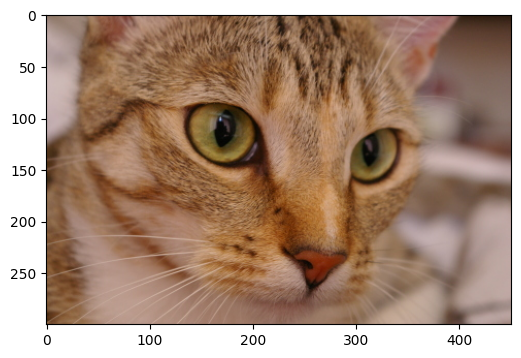


# Prediction (Top 5):
Egyptian_cat : 0.72
tiger_cat    : 0.04
tabby        : 0.03
crossword_puzzle : 0.01
panpipe      : 0.00


In [ ]:
# skimage.dataモジュールのchelsea()関数で「チェルシー」という名前の猫の画像を読み込む
# 読み込んだ画像はkeras.applications.imagenet_utils.preprocess_input()メソッドで
# PyTorchのモデルで使用するために適した形式に前処理する
img = keras.applications.imagenet_utils.preprocess_input(
    chelsea(), mode="torch"
)
# 画像を224x224にリサイズし、バッチ次元を追加する
img = tf.image.resize(img, (224, 224))[None, ...]
# モデルに画像を渡して予測を行う
pred = model(img)
# 予測結果をデコードして、ImageNetのラベルに変換する
pred_dec = keras.applications.imagenet_utils.decode_predictions(pred)[0]

# 画像を表示
print("\n# Image:")
plt.figure(figsize=(6, 6))
plt.imshow(chelsea())
plt.show()
print()

# 上位5つの予測結果を表示
print("# Prediction (Top 5):")
for i in range(5):
    print("{:<12} : {:0.2f}".format(pred_dec[i][1], pred_dec[i][2]))


In [ ]:
# モデルに入力する画像のサイズを (224, 224) に設定
IMAGE_SIZE = (224, 224)

# ハイパーパラメーターの設定
BATCH_SIZE = 32  # バッチサイズ
EPOCHS = 5  # エポック数

# データセットのクラスラベルを設定
# 順序の変更はしないでください
CLASSES = [
    "dandelion",  # タンポポ
    "daisy",  # ヒナギク
    "tulips",  # チューリップ
    "sunflowers",  # ヒマワリ
    "roses",  # バラ
]

# 定数を設定
# ImageNetの全画像から求められた各チャンネルの平均値[0.485, 0.456, 0.406]を利用
# ImageNetの全画像から求められた各チャンネルの標準偏差[0.229, 0.224, 0.225]を利用
# 255を掛けるのは、ImageNetの平均値や標準偏差は各ピクセルを
# [0, 1]の範囲に正規化して求められているため
MEAN = 255 * np.array([0.485, 0.456, 0.406], dtype="float32") # 平均値
STD = 255 * np.array([0.229, 0.224, 0.225], dtype="float32")  # 標準偏差

# データの自動チューニング設定
# データの前処理やバッチ処理のパフォーマンスを最適化するためにAUTOTUNEを使用
AUTO = tf.data.AUTOTUNE


In [ ]:
def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    """
    ・TensorFlow データセットを受け取り、トレーニングモードかどうかを指定し
      画像のサイズを設定する。
    ・内部関数preprocess()で画像の前処理を行う。
    ・トレーニングモードの場合、データセットをシャッフルする
    ・データセットをバッチ化し、プリフェッチ(事前読み込み)を行う
    """
    def preprocess(image, label):
        """
        ・画像とラベルを受け取り、トレーニングモードの場合はデータ拡張を行う。
        ・画像をリサイズし、正規化する
        ・前処理された画像とラベルを返す
        """
        # トレーニング時にデータ拡張を行う
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        # 画像のサイズをリサイズ
        image = tf.image.resize(image, size=image_size, method="bicubic")
        # 画像のピクセル値をImageNetの平均と標準偏差で正規化する
        image = (image - MEAN) / STD
        return image, label

    # トレーニング時にデータセットをシャッフル
    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    # データセットに前処理を適用し、バッチ化し、プリフェッチを行う
    return dataset.map(preprocess, AUTO).batch(BATCH_SIZE).prefetch(AUTO)


In [ ]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",  # ダウンロードするデータセット名
    split=["train[:90%]", "train[90%:]"], # 90%をトレーニング用、10%を検証用に分割
    as_supervised=True,  # データセットを（画像、ラベル）のタプル形式で読み込む
    try_gcs=False,  # TPU用のgcs_pathは不要とする
)

# トレーニングデータセットに前処理を適用
train_dataset = make_dataset(train_dataset, True)
# 検証データセットに前処理を適用
val_dataset = make_dataset(val_dataset, False)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
model = GCViT(**config, num_classes=5)  # GCViTモデルを再構築。クラス数は5に設定
inp = ops.array(np.random.uniform(size=(1, 224, 224, 3)))  # ランダムな入力データを作成
out = model(inp)  # モデルに入力データを通して出力を得る

# 学習済みの重みファイルをダウンロード
ckpt_path = keras.utils.get_file(ckpt_link.split("/")[-1], ckpt_link)
# ダウンロードした重みをモデルに読み込む
model.load_weights(ckpt_path, skip_mismatch=True)

# モデルをコンパイルする。損失関数は"sparse_categorical_crossentropy"
# 最適化アルゴリズムは"adam"、評価指標は"accuracy"
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:591: UserWarning: A total of 1 objects could not be loaded. Example error message for object <Dense name=head, built=True>:

Layer 'head' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=head, built=True>]
  warnings.warn(msg)


In [ ]:
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=EPOCHS, verbose=1
)


Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.6824 - loss: 0.8213 - val_accuracy: 0.8774 - val_loss: 0.3603
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 0.8836 - loss: 0.3508 - val_accuracy: 0.9319 - val_loss: 0.2915
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9135 - loss: 0.2493 - val_accuracy: 0.9019 - val_loss: 0.2856
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9439 - loss: 0.1741 - val_accuracy: 0.9183 - val_loss: 0.2198
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.9381 - loss: 0.1868 - val_accuracy: 0.8311 - val_loss: 0.5427
